In [3]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 13.7 MB/s eta 0:00:00a 0:00:01
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.1
    Uninstalling matplotlib-3.6.1:
      Successfully uninstalled matplotlib-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matrixprofile 1.1.10 requires protobuf==3.11.2, but you have protobuf 4.25.5 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the 

In [7]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
import os

In [36]:
# Parse XML file
def parse_eye_tracking(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    data = []
    for entry in root.iter('gaze'):
        if not entry.get('remark'):
            timestamp = int(entry.get('timestamp'))
            left_gaze_x = float(entry.find('left_eye').get('gaze_point_x'))
            left_gaze_y = float(entry.find('left_eye').get('gaze_point_y'))
            right_gaze_x = float(entry.find('right_eye').get('gaze_point_x'))
            right_gaze_y = float(entry.find('right_eye').get('gaze_point_y'))
            left_pupil_diameter = float(entry.find('left_eye').get('pupil_diameter'))
            right_pupil_diameter = float(entry.find('right_eye').get('pupil_diameter'))
            if not entry.get('ast_structure'):
                token = entry.find('ast_structure').get('token')
                ast_type = entry.find('ast_structure').get('type')
                line = int(entry.find('location').get('line'))
                column = int(entry.find('location').get('column'))
                data.append({
                    'timestamp': timestamp,
                    'left_gaze_x': left_gaze_x,
                    'left_gaze_y': left_gaze_y,
                    'right_gaze_x': right_gaze_x,
                    'right_gaze_y': right_gaze_y,
                    'left_pupil_diameter': left_pupil_diameter,
                    'right_pupil_diameter': right_pupil_diameter,
                    'token': token,
                    'ast_type': ast_type,
                    'line': line,
                    'column': column
                })
    return pd.DataFrame(data)

base_dir = os.getcwd()
xml_path = os.path.join(base_dir, "Mar4-s1a-hl1lbs-pilot-exp", "eye_tracking.xml")

# Load data
eye_data = parse_eye_tracking(xml_path)

In [37]:
eye_data.head()

,timestamp,left_gaze_x,left_gaze_y,right_gaze_x,right_gaze_y,left_pupil_diameter,right_pupil_diameter,token,ast_type,line,column
0,1741116124934,0.352040,0.395309,0.331252,0.303034,3.121338,3.097137,private,PRIVATE_KEYWORD,27,4
1,1741116124950,0.350376,0.398694,0.331450,0.305843,3.109650,3.084488,private,PRIVATE_KEYWORD,27,4
2,1741116124982,0.351809,0.401626,0.333908,0.301151,3.097900,3.075027,private,PRIVATE_KEYWORD,27,5
3,1741116124982,0.349896,0.407603,0.333620,0.302812,3.094086,3.067703,private,PRIVATE_KEYWORD,27,5
4,1741116124982,0.352434,0.402809,0.334443,0.305517,3.074051,3.050430,private,PRIVATE_KEYWORD,27,5


In [44]:
# Calculate time duration in seconds
if not eye_data.empty:
    start_time = eye_data['timestamp'].min()
    end_time = eye_data['timestamp'].max()
    
    # Assuming timestamps are in milliseconds, convert to seconds
    duration_seconds = (end_time - start_time) / 1000
    print(f"Total duration: {duration_seconds:.2f} seconds")

    duration_seconds = (end_time - start_time) / 1000 / 60
    print(f"Total duration: {duration_seconds:.2f} minutes")
    
    # Drop the last 15 seconds of data
    cutoff_time = end_time - (15 * 1000)  # 15 seconds in milliseconds
    trimmed_data = eye_data[eye_data['timestamp'] <= cutoff_time]
    
    print(f"Original data points: {len(eye_data)}")
    print(f"Data points after trimming last 15 seconds: {len(trimmed_data)}")
    
    # Calculate the new duration
    if not trimmed_data.empty:
        new_end_time = trimmed_data['timestamp'].max()
        new_duration_seconds = (new_end_time - start_time) / 1000
        print(f"New duration after trimming: {new_duration_seconds:.2f} seconds")
else:
    print("No data found in the XML file")

Total duration: 550.33 seconds
Total duration: 9.17 minutes
Original data points: 29451
Data points after trimming last 15 seconds: 28213
New duration after trimming: 535.32 seconds


In [38]:
# Calculate pupil dilation changes for each eye
eye_data['left_pupil_dilation_change'] = eye_data['left_pupil_diameter'].diff().fillna(0)
eye_data['right_pupil_dilation_change'] = eye_data['right_pupil_diameter'].diff().fillna(0)

# Identify fixations (minimum threshold of 200 ms on the same token)
fixation_threshold = 200  # in milliseconds
eye_data['fixation'] = (eye_data['timestamp'].diff() >= fixation_threshold).astype(int)
eye_data['fixation'] = eye_data.groupby('token')['fixation'].cumsum()

In [39]:
# Clustering
features = eye_data[['left_gaze_x', 'left_gaze_y', 'right_gaze_x', 'right_gaze_y', 'left_pupil_diameter', 'right_pupil_diameter']]
kmeans = KMeans(n_clusters=3)
eye_data['cluster'] = kmeans.fit_predict(features)

# Anomaly Detection
iso_forest = IsolationForest(contamination=0.1)
eye_data['anomaly'] = iso_forest.fit_predict(features)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [1]:
eye_data['cluster'].value_counts()

NameError: name 'eye_data' is not defined

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


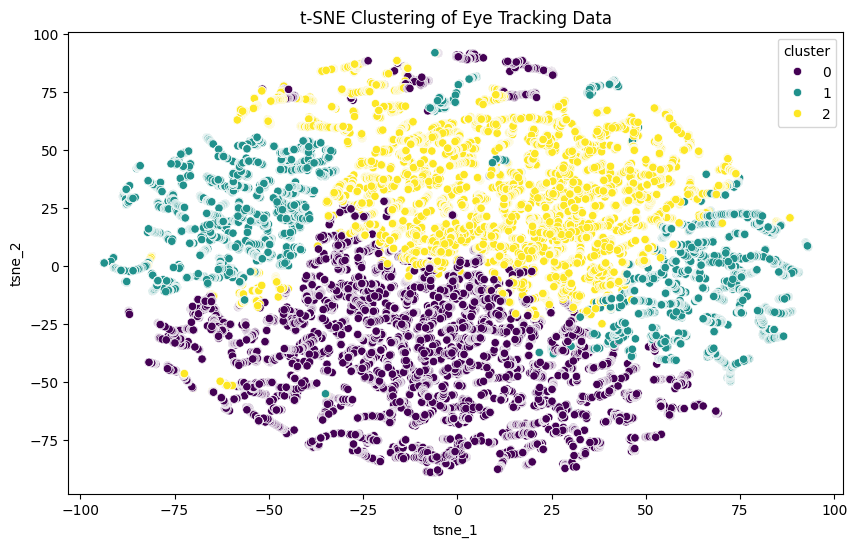

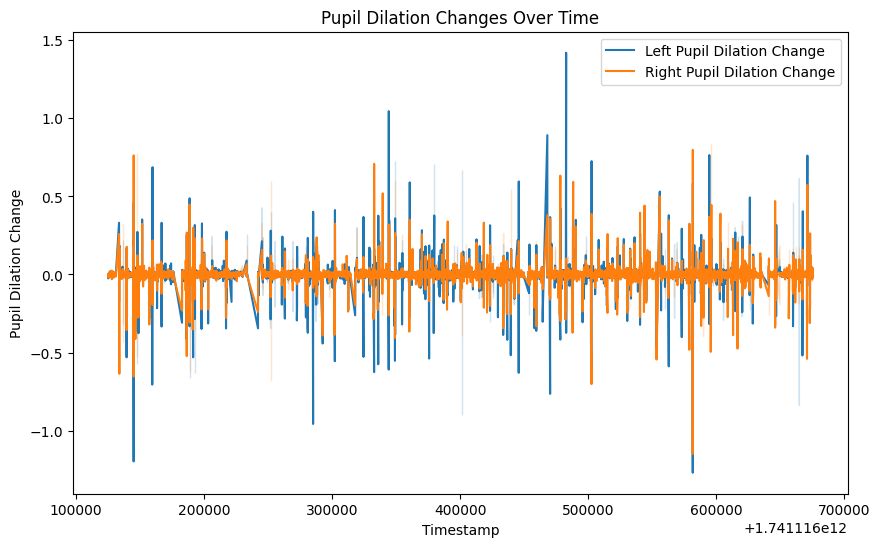

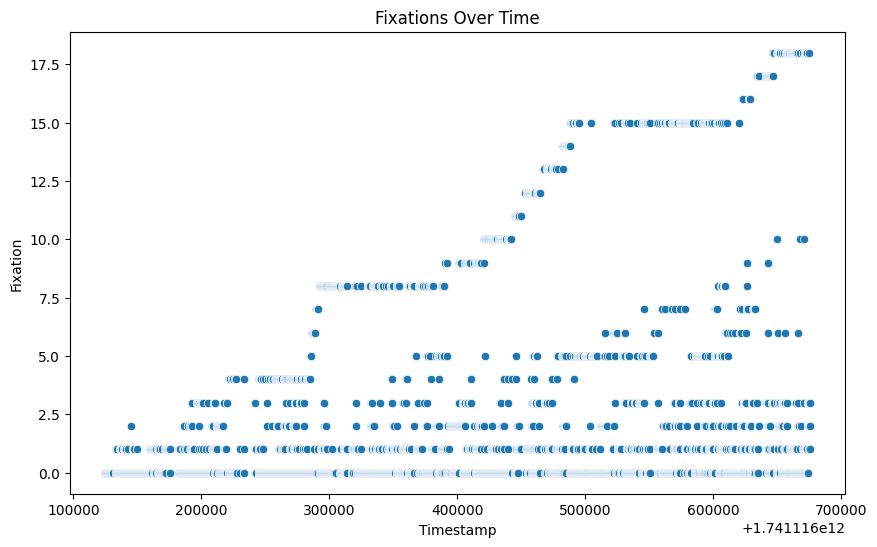

       timestamp  left_gaze_x  left_gaze_y  right_gaze_x  right_gaze_y  \
0  1741116124934     0.352040     0.395309      0.331252      0.303034   
1  1741116124950     0.350376     0.398694      0.331450      0.305843   
2  1741116124982     0.351809     0.401626      0.333908      0.301151   
3  1741116124982     0.349896     0.407603      0.333620      0.302812   
4  1741116124982     0.352434     0.402809      0.334443      0.305517   

   left_pupil_diameter  right_pupil_diameter    token         ast_type  line  \
0             3.121338              3.097137  private  PRIVATE_KEYWORD    27   
1             3.109650              3.084488  private  PRIVATE_KEYWORD    27   
2             3.097900              3.075027  private  PRIVATE_KEYWORD    27   
3             3.094086              3.067703  private  PRIVATE_KEYWORD    27   
4             3.074051              3.050430  private  PRIVATE_KEYWORD    27   

   column  left_pupil_dilation_change  right_pupil_dilation_change  fixati

In [40]:
# Visualization
tsne = TSNE(n_components=2)
eye_data['tsne_1'], eye_data['tsne_2'] = zip(*tsne.fit_transform(features))

plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', data=eye_data, palette='viridis')
plt.title('t-SNE Clustering of Eye Tracking Data')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='timestamp', y='left_pupil_dilation_change', data=eye_data, label='Left Pupil Dilation Change')
sns.lineplot(x='timestamp', y='right_pupil_dilation_change', data=eye_data, label='Right Pupil Dilation Change')
plt.title('Pupil Dilation Changes Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Pupil Dilation Change')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='timestamp', y='fixation', data=eye_data)
plt.title('Fixations Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Fixation')
plt.show()

# Display the processed data
print(eye_data.head())

# Save to CSV for further analysis
eye_data.to_csv('processed_eye_tracking.csv', index=False)
